# Machine Learning Interpretability in Lapse Prediction for Non-Life Insurance Premium

# Prepare Workspace

In [1]:
# to handle datasets
import numpy as np
import random
import pandas as pd

# for plotting
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

# metrics
from sklearn.metrics import roc_auc_score, auc, roc_curve
from sklearn.metrics import confusion_matrix
# to split data set 
from sklearn.model_selection import train_test_split
# feature scaling
from sklearn.preprocessing import RobustScaler
# to handle imbalanced data set
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from collections import Counter

# models
from sklearn.ensemble import GradientBoostingClassifier


# interpretability
import eli5
from eli5.sklearn import PermutationImportance
from sklearn.inspection import PartialDependenceDisplay
import shap
shap.initjs()
import lime
import lime.lime_tabular

seed_value = 0
random.seed(seed_value)
np.random.seed(seed_value)

import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('eudirectlapse.csv')

# Data set Overview

In [3]:
# Dimensions of data set
print(df.shape)

(23060, 19)


In [4]:
# List types for each attribute
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23060 entries, 0 to 23059
Data columns (total 19 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   lapse                 23060 non-null  int64  
 1   polholder_age         23060 non-null  int64  
 2   polholder_BMCevol     23060 non-null  object 
 3   polholder_diffdriver  23060 non-null  object 
 4   polholder_gender      23060 non-null  object 
 5   polholder_job         23060 non-null  object 
 6   policy_age            23060 non-null  int64  
 7   policy_caruse         23060 non-null  object 
 8   policy_nbcontract     23060 non-null  int64  
 9   prem_final            23060 non-null  float64
 10  prem_freqperyear      23060 non-null  object 
 11  prem_last             23060 non-null  float64
 12  prem_market           23060 non-null  float64
 13  prem_pure             23060 non-null  float64
 14  vehicl_age            23060 non-null  int64  
 15  vehicl_agepurchase 

In [5]:
# Take a peek at the first rows of the data
df.head()

lapse  polholder_age polholder_BMCevol polholder_diffdriver  \
0      0             38            stable         only partner   
1      1             35            stable                 same   
2      1             29            stable                 same   
3      0             33              down                 same   
4      0             50            stable                 same   

  polholder_gender polholder_job  policy_age              policy_caruse  \
0             Male        normal           1  private or freelance work   
1             Male        normal           1  private or freelance work   
2             Male        normal           0  private or freelance work   
3           Female       medical           2  private or freelance work   
4             Male        normal           8                    unknown   

   policy_nbcontract  prem_final prem_freqperyear  prem_last  prem_market  \
0                  1      232.46       4 per year     232.47       221.56   
1                  1      208.53       4 per year     208.54       247.56   
2                  1      277.34       1 per year     277.35       293.32   
3                  1      239.51       4 per year     244.40       310.91   
4                  1      554.54       4 per year     554.55       365.46   

   prem_pure  vehicl_age  vehicl_agepurchase       vehicl_garage  \
0     243.59           9                   8      private garage   
1     208.54          15                   7      private garage   
2     277.35          14                   6  underground garage   
3     219.95          17                  10              street   
4     519.50          16                   8              street   

  vehicl_powerkw vehicl_region  
0         225 kW          Reg7  
1         100 kW          Reg4  
2         100 kW          Reg7  
3          75 kW          Reg5  
4          75 kW         Reg14

# Pre-Processing

In [6]:
# Split data set between target variable and features
X_full = df.copy()
y = X_full.lapse
X_full.drop(['lapse'], axis=1, inplace=True)

### Handling Numerical Features

In [7]:
# Select numerical columns
numerical_cols = [cname for cname in X_full.columns if 
                X_full[cname].dtype in ['float64','int64']]

In [8]:
# Subset with numerical features
num = X_full[numerical_cols]
num.columns

Index(['polholder_age', 'policy_age', 'policy_nbcontract', 'prem_final',
       'prem_last', 'prem_market', 'prem_pure', 'vehicl_age',
       'vehicl_agepurchase'],
      dtype='object')

In [9]:
# drop no correlated features with target variable by Kendall's test
to_drop = ['policy_nbcontract','vehicl_agepurchase']
num_ = num.drop(num[to_drop], axis=1)

In [10]:
num_o = num_.copy()

In [11]:
# outliers correction
for col in num_o.columns:
    q75, q25 = np.percentile(num_o[col].dropna(), [75 ,25])
    iqr = q75 - q25 
    min = q25 - (iqr*1.5)
    max = q75 + (iqr*1.5) 
    num_o[col].loc[num_o[col] < min] = min
    num_o[col].loc[num_o[col] > max] = max

### Handling Categorical Features 

In [12]:
# let's have a look at how many labels for categorical features
for col in X_full.columns:
    if X_full[col].dtype =="object":
        print(col, ': ', len(X_full[col].unique()), ' labels')

polholder_BMCevol :  3  labels
polholder_diffdriver :  7  labels
polholder_gender :  2  labels
polholder_job :  2  labels
policy_caruse :  3  labels
prem_freqperyear :  4  labels
vehicl_garage :  8  labels
vehicl_powerkw :  11  labels
vehicl_region :  14  labels


In [13]:
# Select categorical columns with relatively low cardinality (convenient but arbitrary)
categorical_cols = [cname for cname in X_full.columns if
                    X_full[cname].nunique() <= 15 and 
                    X_full[cname].dtype == "object"]

In [14]:
# Subset with categorical features
cat = X_full[categorical_cols]
cat.columns


Index(['polholder_BMCevol', 'polholder_diffdriver', 'polholder_gender',
       'polholder_job', 'policy_caruse', 'prem_freqperyear', 'vehicl_garage',
       'vehicl_powerkw', 'vehicl_region'],
      dtype='object')

In [15]:
# drop no correlated features with target variable by Chi-Square test
to_drop=['vehicl_powerkw']
cat_ = cat.drop(cat[to_drop], axis=1)

### One-Hot Encoding into k-1 dummy variables

In [16]:
# Encode the categorical data 
dummy_cat = pd.concat([pd.get_dummies(cat_.polholder_BMCevol, prefix='BMCevol',drop_first=True), 
                       pd.get_dummies(cat_.polholder_diffdriver, prefix= 'diffdriver', drop_first=True), 
                       pd.get_dummies(cat_.polholder_gender, prefix= 'gender', drop_first=True),
                       pd.get_dummies(cat_.polholder_job, prefix='job',drop_first=True),
                       pd.get_dummies(cat_.policy_caruse, prefix='caruse',drop_first=True),
                       pd.get_dummies(cat_.prem_freqperyear, prefix='freqperyear',drop_first=True),
                       pd.get_dummies(cat_.vehicl_garage, prefix='garage',drop_first=True),
                       pd.get_dummies(cat_.vehicl_region, prefix='region',drop_first=True)], axis=1)
dummy_cat = dummy_cat.astype(int)

In [17]:
# Grasp all
X_all = pd.concat([dummy_cat, num_o], axis=1)

### Zero/Close Zero Variance Predictors

In [18]:
# Find features with variance equal zero or lower than 0.05
to_drop = [col for col in X_all.columns if np.var(X_all[col]) < 0.05]
to_drop

['BMCevol_up',
 'diffdriver_commercial',
 'diffdriver_learner 17',
 'diffdriver_unknown',
 'garage_private estate',
 'garage_underground garage',
 'region_Reg10',
 'region_Reg11',
 'region_Reg13',
 'region_Reg2',
 'region_Reg6',
 'region_Reg9']

In [19]:
# Drop features 
X_all_v = X_all.drop(X_all[to_drop], axis=1)

### Correlated Predictors

In [20]:
# Correlation heatmap
corr_matrix = X_all_v.corr()

In [21]:
# Select correlated features and removed it
# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
# Find index of feature columns with correlation greater than 0.75
to_drop = [column for column in upper.columns if any(upper[column].abs() > 0.75)]
to_drop

['caruse_unknown', 'prem_last', 'prem_market', 'prem_pure']

In [22]:
# Drop features 
X_all_c = X_all_v.drop(X_all_v[to_drop], axis=1)

### Normalization

In [23]:
# Normalization of data
scaling = RobustScaler()

In [24]:
# Normalization of data
X_all_sc = scaling.fit_transform(X_all_c)

### Split data set

In [25]:
# Break off test set from training data
X_train, X_test, y_train, y_test = train_test_split(X_all_sc, y, train_size=0.8, stratify=y,
                                                                random_state=0)

In [26]:
# OVERSAMPLING
ros = RandomOverSampler(random_state=0)
X_train_ros_resampled, y_train_ros_resampled = ros.fit_resample(X_train, y_train)
print(sorted(Counter(y_train_ros_resampled).items()))

[(0, 16085), (1, 16085)]


In [27]:
# UNDERSAMPLING
rus = RandomUnderSampler(random_state=0)
X_train_rus_resampled, y_train_rus_resampled = rus.fit_resample(X_train, y_train)
print(sorted(Counter(y_train_rus_resampled).items()))

[(0, 2363), (1, 2363)]


In [28]:
# SMOTE
sm = SMOTE(random_state=0)
X_train_smote_resampled, y_train_smote_resampled = sm.fit_resample(X_train, y_train)
print(sorted(Counter(y_train_smote_resampled).items()))

[(0, 16085), (1, 16085)]


# Modelling

In [29]:
# Define the model
GBM_model_ROS = GradientBoostingClassifier(random_state=0).fit(X_train_ros_resampled, y_train_ros_resampled)
GBM_model_RUS = GradientBoostingClassifier(random_state=0).fit(X_train_rus_resampled, y_train_rus_resampled)
GBM_model_SMOTE = GradientBoostingClassifier(random_state=0).fit(X_train_smote_resampled, y_train_smote_resampled)



# Evaluation

In [30]:
predictions_tr_ros = GBM_model_ROS.predict_proba(X_train_ros_resampled)[:, 1] 
predictions_te_ros = GBM_model_ROS.predict_proba(X_test)[:, 1]
predictions_tr_rus = GBM_model_RUS.predict_proba(X_train_rus_resampled)[:, 1] 
predictions_te_rus = GBM_model_RUS.predict_proba(X_test)[:, 1]
predictions_tr_smote = GBM_model_SMOTE.predict_proba(X_train_smote_resampled)[:, 1] 
predictions_te_smote = GBM_model_SMOTE.predict_proba(X_test)[:, 1]

In [31]:
roc_auc_train_ros = roc_auc_score(y_train_ros_resampled, predictions_tr_ros)
roc_auc_test_ros = roc_auc_score(y_test, predictions_te_ros)
roc_auc_train_rus = roc_auc_score(y_train_rus_resampled, predictions_tr_rus)
roc_auc_test_rus = roc_auc_score(y_test, predictions_te_rus)
roc_auc_train_smote = roc_auc_score(y_train_smote_resampled, predictions_tr_smote)
roc_auc_test_smote = roc_auc_score(y_test, predictions_te_smote)

In [40]:
d1 = {'evaluation': ['Roc_Auc','Roc_Auc','Roc_Auc'],
     'model': ['GBM_ROS','GBM_RUS','GBM_SMOTE'],
    'train': [roc_auc_train_ros,roc_auc_train_rus,roc_auc_train_smote],
    'test': [roc_auc_test_ros,roc_auc_test_rus,roc_auc_test_smote]
        }
df1 = pd.DataFrame(data=d1, columns=['model','evaluation','train','test'])
print('Evaluation on churn prediction')
df1

Evaluation on churn prediction


model evaluation     train      test
0    GBM_ROS    Roc_Auc  0.690052  0.612770
1    GBM_RUS    Roc_Auc  0.713212  0.609316
2  GBM_SMOTE    Roc_Auc  0.937752  0.586659

In [41]:
def plot_roc_auc(y_test, y_score, classes):
    plt.figure()
    fpr, tpr, _ = roc_curve(y_test, y_score)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr,color='darkorange', lw=2, label='ROC curve (area = {0:0.2f})'.format(roc_auc))
    plt.plot([0, 1], [0, 1],color='navy', lw=2, linestyle='--' )
    plt.xlim([-0.01, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()

ROC on train


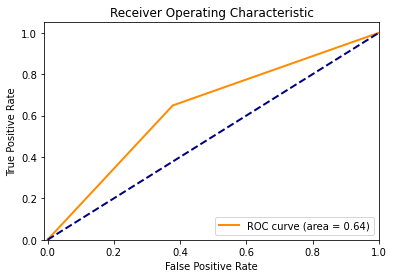

In [42]:
print('ROC on train')
plot_roc_auc(y_train_ros_resampled, predictions_tr_ros, 2)

ROC on test


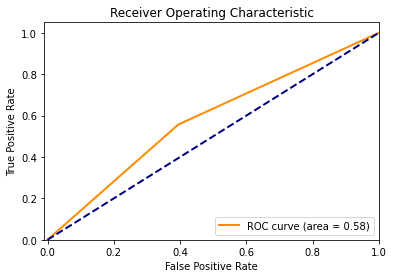

In [43]:
print('ROC on test')
plot_roc_auc(y_test, predictions_te_ros, 2)

In [44]:
predictions_tr_ros = GBM_model_ROS.predict(X_train_ros_resampled)
predictions_te_ros = GBM_model_ROS.predict(X_test)

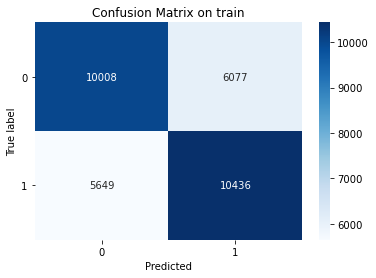

In [45]:
# Plot confusion matrix
cm = confusion_matrix(y_train_ros_resampled, predictions_tr_ros)
sns.heatmap(cm, annot=True, fmt='d', cmap=plt.cm.Blues, cbar=True)
plt.title("Confusion Matrix on train")
plt.xlabel('Predicted')
plt.ylabel('True label')
plt.yticks(rotation=0)
plt.show()

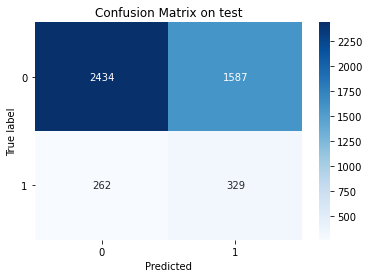

In [46]:
# Plot confusion matrix
cm = confusion_matrix(y_test, predictions_te_ros)
sns.heatmap(cm, annot=True, fmt='d', cmap=plt.cm.Blues, cbar=True)
plt.title("Confusion Matrix on test")
plt.xlabel('Predicted')
plt.ylabel('True label')
plt.yticks(rotation=0)
plt.show()

# Feature Importance

Train GBM


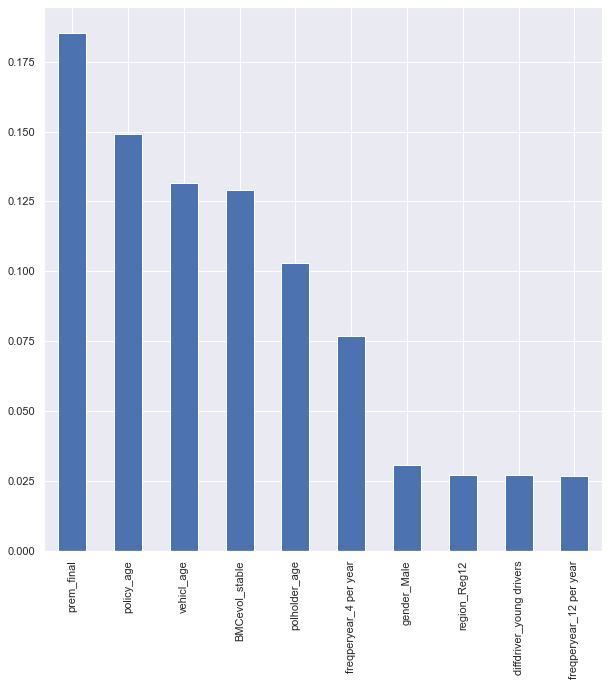

In [47]:
# Top relevant features Logistic Regression train
sns.set(rc ={'figure.figsize': (10, 10)})
feature_importances = GBM_model_ROS.feature_importances_
print("Train GBM")
(pd.Series(feature_importances, index=X_all_c.columns).nlargest(10).plot(kind='bar'))
plt.show()

Test GBM


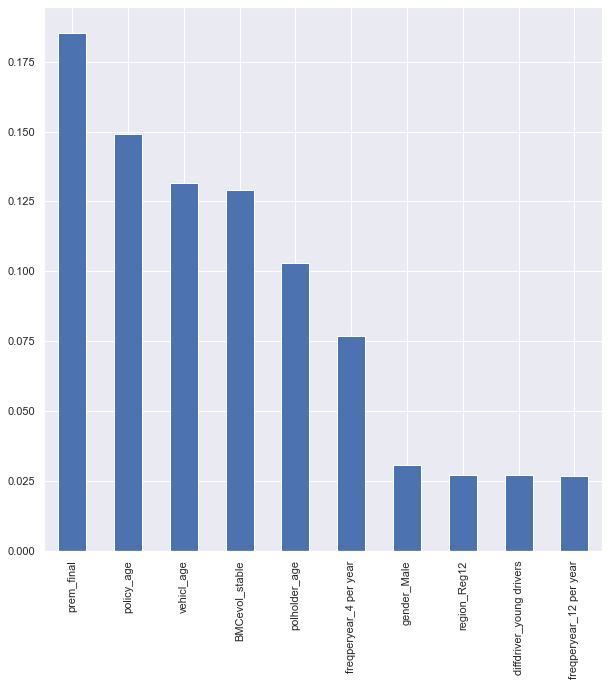

In [48]:
# Top relevant features Logistic Regression Test
sns.set(rc ={'figure.figsize': (10, 10)})
feature_importances = GBM_model_ROS.feature_importances_
print("Test GBM")
(pd.Series(feature_importances, index=X_all_c.columns).nlargest(10).plot(kind='bar'))
plt.show()

# Permutation Feature Importance

In [49]:
# Permutation importance 
print('GBM Features Permutation Importance on train')
perm = PermutationImportance(GBM_model_ROS, random_state=0).fit(X_train_ros_resampled, y_train_ros_resampled)
eli5.show_weights(perm, feature_names = X_all_c.columns.tolist())

GBM Features Permutation Importance on train


In [50]:
# Permutation importance 
print('GBM Features Permutation Importance on test')
perm = PermutationImportance(GBM_model_ROS, random_state=0).fit(X_test, y_test)
eli5.show_weights(perm, feature_names = X_all_c.columns.tolist())

GBM Features Permutation Importance on test


# Partial Dependence Plots

GBM


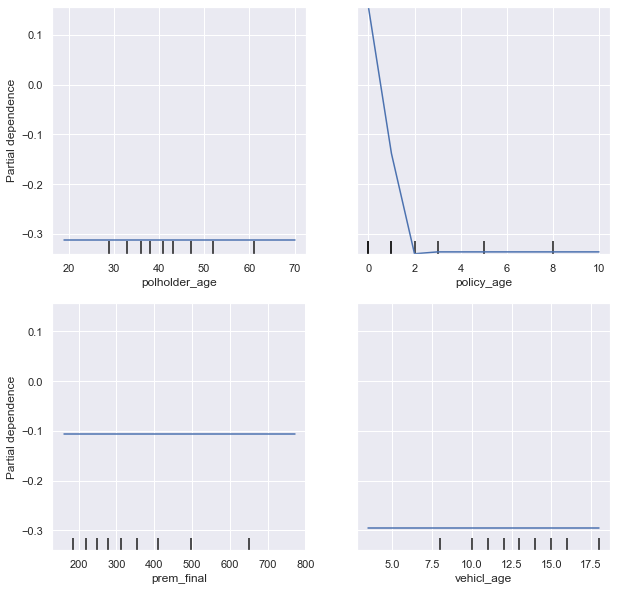

In [51]:
sns.set(rc ={'figure.figsize': (10, 10)})
fig, ax = plt.subplots(2,2)
PartialDependenceDisplay.from_estimator(GBM_model_ROS,X_all_c,['polholder_age', 'policy_age', 'prem_final', 'vehicl_age'], 
                                        kind='average', ax=ax)
print("GBM")
plt.show()
    

# Individual Conditional Expectation (ICE) Plot 

GBM


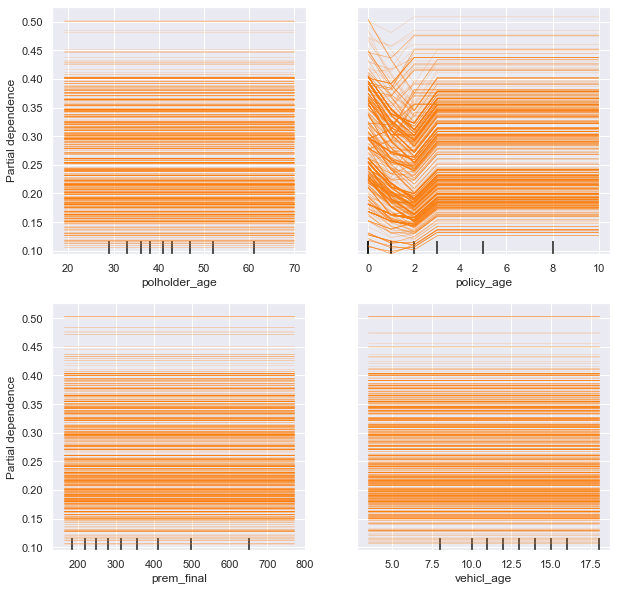

In [52]:
sns.set(rc ={'figure.figsize': (10, 10)})
fig, ax = plt.subplots(2,2)
PartialDependenceDisplay.from_estimator(GBM_model_ROS,X_all_c,['polholder_age', 'policy_age', 'prem_final', 'vehicl_age'], 
                                kind='individual', ice_lines_kw={"color": "tab:orange", "alpha": 0.3, "linewidth": 0.5},ax=ax)
print("GBM")
plt.show()

# SHAP

GBM SHAP Train Values


 99%|===================| 31760/32170 [00:38<00:00]        

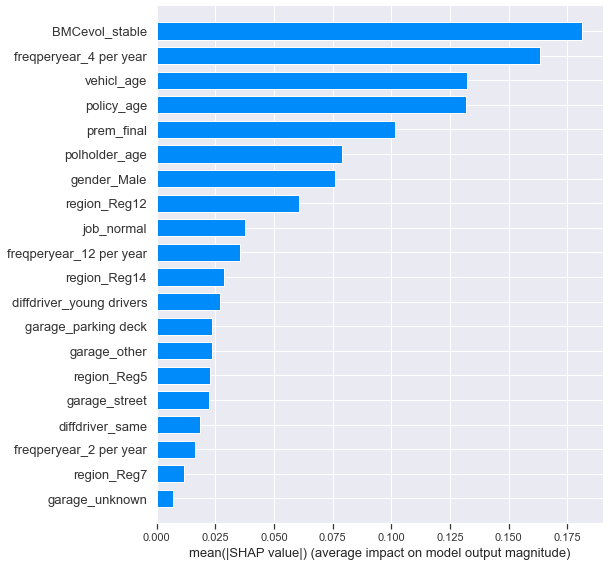

In [54]:
# SHAP Values Interpretability train
print("GBM SHAP Train Values")
feature_names=X_all_c.columns
shap_train_values = shap.TreeExplainer(GBM_model_ROS, data=X_train_ros_resampled).shap_values(X_train_ros_resampled)
shap.summary_plot(shap_train_values, feature_names, plot_type='bar')

GBM SHAP test Values


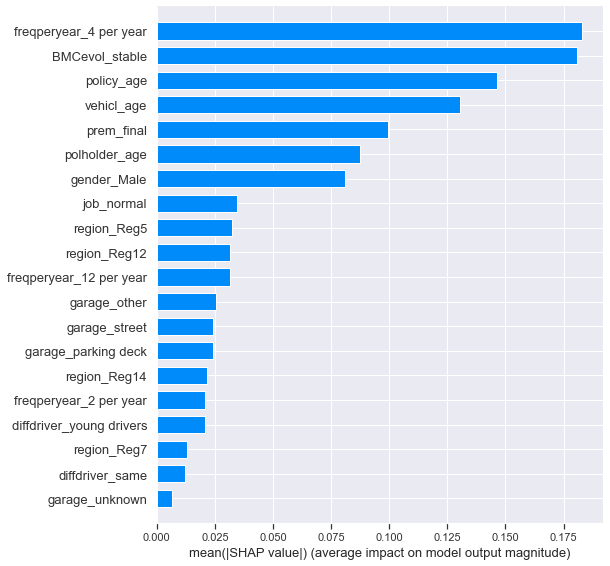

In [55]:
# SHAP Values Interpretability test
print("GBM SHAP test Values")
feature_names=X_all_c.columns
masker = shap.maskers.Independent(X_test)
shap_test_values = shap.TreeExplainer(GBM_model_ROS, data=X_test).shap_values(X_test)
shap.summary_plot(shap_test_values, feature_names, plot_type='bar')

# LIME

In [56]:
explainer = lime.lime_tabular.LimeTabularExplainer(X_train_ros_resampled, mode="classification",
                                              class_names=['0','1'], verbose='True',
                                              feature_names=X_all_c.columns)

explainer

In [57]:
i = 1000

print('GBM LIME Train Values')
exp = explainer.explain_instance(X_train_ros_resampled[i], GBM_model_ROS.predict_proba, num_features=10)
exp.show_in_notebook(show_table=True)


GBM LIME Train Values
Intercept 0.4909189871685218
Prediction_local [0.40779679]
Right: 0.4011420879271636


In [58]:
i = 1000

print('GBM LIME Test Values')
exp = explainer.explain_instance(X_test[i], GBM_model_ROS.predict_proba, num_features=10)
exp.show_in_notebook(show_table=True)


GBM LIME Test Values
Intercept 0.44444013742474336
Prediction_local [0.46831087]
Right: 0.5837821903770994
